In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.nn import Conv2d, Linear

In [47]:
class CNN(torch.nn.Module):
    def __init__(self, hidden_channels, activationCNN, activationOut):
        super(CNN, self).__init__()
        torch.manual_seed(42)

        # in_channels=1 bo obraz jest jednokanałowy(greyscale)
        self.conv1 = Conv2d(1, hidden_channels, kernel_size=3, padding=1) # kernel 3x3, padding=1 pixel czyli output ma ten sam size czyli 28x28
        self.conv2 = Conv2d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1)
        self.fullyConnected = Linear(hidden_channels * 2 * 7 * 7, 10) # (hidden channels * 2 * 2) to  wyjscie z warstwy 2 konwolucyjnej a 7x7 to dlatego ze poczatkowy rozmiar obrazka jest 28x28
        # alepo każdej warstwie konwolucyjnej był pooling 2x2, który redukuje wektor wejściowy, czyli 28:(2x2) = 7
        self.activationCNN = activationCNN
        self.activationOut = activationOut

    def forward(self, x):
        x = self.conv1(x)
        x = self.activationCNN(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = self.activationCNN(x)
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
        return x

In [44]:
class CNN(torch.nn.Module):
    def __init__(self, hidden_channels, activationCNN, activationOut):
        super(CNN, self).__init__()
        torch.manual_seed(42)
        
        self.conv1 = Conv2d(in_channels=1, out_channels=hidden_channels, kernel_size=3, padding=1) # wejście ([hidden_channels, 28x28])
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # po poolingu rozmiar sie zmniejsza [hidden_channels, 14x14]
        self.conv2 = Conv2d(in_channels=hidden_channels, out_channels=hidden_channels*2, kernel_size=3, padding=1) 
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # po poolingu rozmiar sie zmniejsza [hidden_channels, 7x7]
        self.conv3 = Conv2d(in_channels=hidden_channels*2, out_channels=hidden_channels*2*2, kernel_size=3, padding=1) 
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # po poolingu rozmiar sie zmniejsza [hidden_channels, 3x3]
        self.conv4 = Conv2d(in_channels=hidden_channels*2*2, out_channels=hidden_channels*2*2*2, kernel_size=3, padding=1)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=2, stride=2) # po poolingu rozmiar sie zmniejsza [hidden_channels, 1x1]
        self.fullyConnected = Linear(in_features=(hidden_channels*2*2*2), out_features=100) # tu jest tylko 
        self.fullyConnected2 = Linear(in_features=100, out_features=10) # tu mi wychodzi, że powinno być jeszcze 2*2 w input_shapie
        
        self.activationCNN = activationCNN
        self.activationOut = activationOut

    def forward(self, x):
        x = self.conv1(x)
        x = self.activationCNN(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.activationCNN(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.activationCNN(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.activationCNN(x)
        x = self.pool4(x)
        
        x = x.view(x.size(0), -1)
        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected(x))
            
        if self.activationOut == torch.softmax:
            x = self.activationOut(self.fullyConnected2(x), dim=1)
        else:
            x = self.activationOut(self.fullyConnected2(x))
        return x

In [3]:
criterion = torch.nn.CrossEntropyLoss()

In [4]:
train_dataset = torchvision.datasets.MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [6]:
def train():
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss/len(train_loader.dataset)

In [98]:
def test():
    model.eval()
    correct = 0
    predictions = []
    targets = []
    inputs = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            predictions.append(pred)
            targets.append(target)
            inputs.append(data)
            correct += pred.eq(target.view_as(pred)).sum().item()
    print(correct)
    print(len(test_loader.dataset))
    accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy, predictions, targets, inputs

In [8]:
# Tablica do przechowywania wartości accuracy z poszczególnych modeli
accuracies = []
# Tablica do przechowywania hiperparametrów danego modelu
params = []

In [92]:
# Funckja do trenowania modelu przez zadaną liczbę epok
def final_train(epochs):
    losses = []
    for epoch in range(0, epochs):
        loss = train()
        losses.append(loss)
    return losses

In [10]:
# Funkcja stworzona dlatego, że optimizer trzeba stworzyć po modelu(przyjmiuje model.parameters() jako parametr) więc nie możemy zadeklarować tablicy optimizerów, dlatego stworzymy tablice, 
# która zawiera tylko nazwy, a potem po stworzeniu modelu użyjemy tej funkcji żeby stworzyć odpowiedni optimizer
def assign_optimizer(model, optimizer_name):
    if optimizer_name == 'Adam':
        return torch.optim.Adam(model.parameters(), lr=0.01)
    elif optimizer_name == 'SGD':
        return torch.optim.SGD(model.parameters(), lr=0.01)
    elif optimizer_name == 'Adagrad':
        return torch.optim.Adagrad(model.parameters(), lr=0.01)
    else:
        return -1

In [51]:
# Definiujemy tablice hiperparametrów, które będziemy testować
hidden_channels_tab = [16, 32, 64]
activationCNN_tab = [torch.relu, torch.tanh, F.leaky_relu]
activationOut_tab = [torch.softmax, torch.sigmoid]
optimizers_tab = ['SGD', 'Adam', 'Adagrad']

<font size='5'>Wyniki dużej sieci z 4 warstwami CNN i 2 liniowymi </font>

In [46]:
for h_c in hidden_channels_tab:
    for aCNN in activationCNN_tab:
        for aOut in activationOut_tab:
            for opt in optimizers_tab:
                model = CNN(hidden_channels=h_c, activationCNN=aCNN, activationOut=aOut)
                optimizer = assign_optimizer(model, opt)
                loss = final_train(10)
                accuracies.append(test())
                params.append(['hidden_chanels: ' + str(h_c), 'activationGNN: ' + str(aCNN), 'activationOut: ' + str(aOut), 'optimizer: ' + opt,])
                print(accuracies[-1])

1135
10000
11.35


<font size='5'>Wyniki małej sieci z 2 warstwami CNN i 1 liniowa </font>

In [49]:
for h_c in hidden_channels_tab:
    for aCNN in activationCNN_tab:
        for aOut in activationOut_tab:
            for opt in optimizers_tab:
                model = CNN(hidden_channels=h_c, activationCNN=aCNN, activationOut=aOut)
                optimizer = assign_optimizer(model, opt)
                loss = final_train(10)
                accuracies.append(test())
                params.append(['hidden_chanels: ' + str(h_c), 'activationGNN: ' + str(aCNN), 'activationOut: ' + str(aOut), 'optimizer: ' + opt,])
                print(accuracies[-1])

9629
10000
96.29


In [ ]:
# Tablica do przechowywania wartości accuracy z poszczególnych modeli
accuracies = []
# Tablica do przechowywania hiperparametrów danego modelu
params = []
for h_c in hidden_channels_tab:
    for aCNN in activationCNN_tab:
        for aOut in activationOut_tab:
            for opt in optimizers_tab:
                model = CNN(hidden_channels=h_c, activationCNN=aCNN, activationOut=aOut)
                optimizer = assign_optimizer(model, opt)
                loss = final_train(10) # ewentualnie tu można mieć loss danego modelu, ale to chyba potrzebne tylko dla tego najlepszego modelu
                accuracies.append(test())
                params.append(['hidden_chanels: ' + str(h_c), 'activationGNN: ' + str(aCNN), 'activationOut: ' + str(aOut), 'optimizer: ' + opt,])

In [53]:
print(accuracies)
for elem in params:
    print(elem)

[84.79, 96.29, 78.68, 91.79, 95.43, 97.99, 91.95, 97.47, 98.07, 89.73, 97.41, 97.75, 84.8, 96.97, 98.21, 91.81, 97.37, 98.1, 85.45, 76.8, 79.48, 92.47, 91.55, 98.51, 92.89, 66.28, 9.8, 90.93, 85.86, 98.42, 85.45, 93.97, 89.33, 92.46, 88.97, 98.61, 77.01, 57.38, 79.33, 93.09, 10.09, 89.26, 94.14, 10.1, 98.79, 92.16, 10.32, 10.32, 77.05, 45.74, 79.35, 93.1, 10.09, 98.84]
['hidden_chanels: 16', 'activationGNN: <built-in method relu of type object at 0x00007FFC68436F40>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: SGD']
['hidden_chanels: 16', 'activationGNN: <built-in method relu of type object at 0x00007FFC68436F40>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: Adam']
['hidden_chanels: 16', 'activationGNN: <built-in method relu of type object at 0x00007FFC68436F40>', 'activationOut: <built-in method softmax of type object at 0x00007FFC68436F40>', 'optimizer: Adagrad']
['hidden_chanels: 16', 

In [55]:
print(accuracies.index(max(accuracies)))

53


In [57]:
print(accuracies[53])

98.84


In [58]:
print(params[53])

['hidden_chanels: 64', 'activationGNN: <function leaky_relu at 0x0000027775B6ED30>', 'activationOut: <built-in method sigmoid of type object at 0x00007FFC68436F40>', 'optimizer: Adagrad']


In [54]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [93]:
model = CNN(hidden_channels=64, activationCNN=F.leaky_relu, activationOut=torch.sigmoid)
optimizer = assign_optimizer(model, "Adagrad")
losses = final_train(10)

C:\Users\MICHU13\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


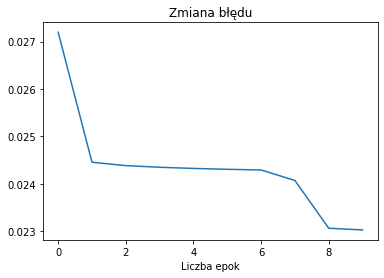

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

losses_float = [float(loss) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
sns.lineplot(loss_indices, losses_float)

plt.title('Zmiana błędu')
plt.xlabel('Liczba epok')
plt.show()

In [99]:
acc, predictions, targets, inputs = test()

9884
10000


In [106]:
print(len(inputs))

157


In [107]:
inps = []
for elems in inputs:
    for batch in elems:
        inps.append(batch[0])

In [117]:
# przepisanie poniewaz tu jest 2 wymiarowa lista a musi byc jedno -> bo tu jest tymi paczkami batch_size (=64) to pakowane
targs = []
for tensor in targets:
    for elem in tensor:
        targs.append(int(elem))

In [118]:
# przepisanie poniewaz tu jest 2 wymiarowa lista a musi byc jedno -> bo tu jest tymi paczkami batch_size (=64) to pakowane
preds = []
for tensor in predictions:
    for elem in tensor:
        preds.append(int(elem))

In [89]:
print("Accuracy: " + str(accuracy_score(targs, preds)))
print("Precision(weighted): " + str(precision_score(targs, preds, average='weighted')))
print("Precision(macro): " + str(precision_score(targs, preds, average='macro')))
print("Recall(weighted): " + str(recall_score(targs, preds, average='weighted')))
print("Recall(macro): " + str(recall_score(targs, preds, average='macro')))
print("F1(weighted): " + str(f1_score(targs, preds, average='weighted')))
print("F1(macro): " + str(f1_score(targs, preds, average='macro')))

Accuracy: 0.9884
Precision(weighted): 0.9884213668466405
Precision(macro): 0.9884067097749245
Recall(weighted): 0.9884
Recall(macro): 0.98827972453744
F1(weighted): 0.9883989815901612
F1(macro): 0.9883313821651754


In [72]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

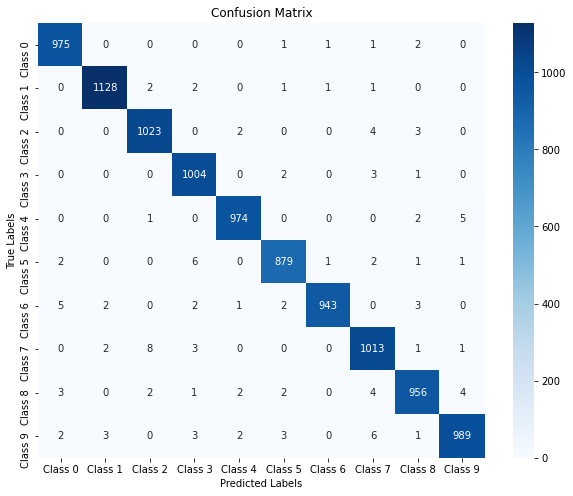

In [91]:
cm = confusion_matrix(targs, preds)

classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=classes, yticklabels=classes, ax=ax)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

In [119]:
indexes = []
for i in range(len(preds)):
    if targs[i] != preds[i]:
        indexes.append(i)
        break
for i in range(len(preds)):
    if targs[-i] != preds[-i]:
        indexes.append(-i)
        break

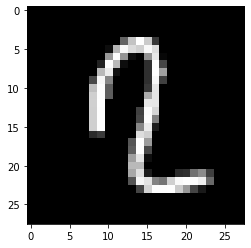

In [120]:
plt.imshow(inps[indexes[0]], cmap='gray')
plt.show()

In [121]:
print(targs[indexes[0]])

2


In [122]:
print(preds[indexes[0]])

8


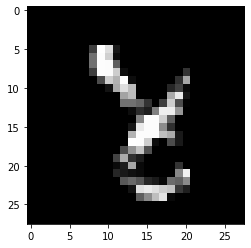

In [123]:
plt.imshow(inps[indexes[1]], cmap='gray')
plt.show()

In [124]:
print(targs[indexes[1]])

8


In [125]:
print(preds[indexes[1]])

2


In [132]:
from torchsummary import summary

In [134]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
            Conv2d-2          [-1, 128, 14, 14]          73,856
            Linear-3                   [-1, 10]          62,730
Total params: 137,226
Trainable params: 137,226
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.57
Params size (MB): 0.52
Estimated Total Size (MB): 1.10
----------------------------------------------------------------
